# Portfolio optimization

## Use Fema French model as an exmaple

In [1]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import numpy as np
import warnings
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy.stats as stats
from matplotlib.gridspec import GridSpec
from functools import cache
from tqdm import tqdm
from Utils import *
from datetime import datetime, date
from pandas.tseries.offsets import BDay

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.4f}'.format

## Compute all factor exposures for SP500 stocks

[*********************100%***********************]  503 of 503 completed


100%|██████████| 503/503 [00:00<00:00, 958.77it/s] 


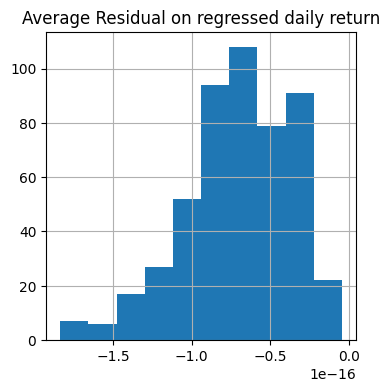

In [2]:
tickers = get_sp500_tickers()
raw = yf.download(tickers=tickers,period="2y",interval="1d",auto_adjust=True).reset_index()

ff3 = get_daily_ff3_returns()
# there is a stock called RF
ff3 = ff3.rename(columns={'RF':'RFree'})
df = raw.copy()
df = df[['Date','Close']]
df['Close'] = df['Close'].pct_change().fillna(0)
df = df.droplevel(0, axis=1)
df = df.rename(columns={'': 'Date'})
df = pd.merge(df, ff3, how='inner', on='Date', validate='1:1')

# residual matrix, we will need this to compute the factor portfolio covariance
res_matrix = []

ff3_factors_arr = []
with tqdm(total=len(tickers)) as pbar:
    for ticker in tickers:    
        X = df[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)
        y = df[ticker] - df['RFree']
        
        ff_model = sm.OLS(y, X).fit()
        intercept, b1, b2, b3 = ff_model.params
        intercept_p, b1_p, b2_p, b3_p = ff_model.pvalues
        row = {
            'ticker': ticker,
            'f_mkt': b1,
            'f_smb': b2,
            'f_hml': b3,
            'f_const': intercept,            
            'p_mkt': b1_p,
            'p_smb': b2_p,
            'p_hml': b3_p,
            'p_const': intercept_p,
            'is_mkt_f_true': b1_p < 0.05,
            'is_smb_f_true': b2_p < 0.05,
            'is_hml_f_true': b3_p < 0.05,
            'is_const_f_true': intercept_p < 0.05,
        }
        ff3_factors_arr.append(row)
        res_matrix.append(ff_model.resid)
        pbar.update(1)

ff3_factors = pd.DataFrame(ff3_factors_arr)
res_matrix = np.array(res_matrix)

plt.figure(figsize=(4,4))
plt.hist(np.mean(res_matrix, axis=1))
plt.title("Average Residual on regressed daily return")
plt.grid()
plt.show()

## Restrict universe to assets where all factor pvalue < 5%

In [3]:
ff3 = get_daily_ff3_returns()
ff3 = ff3[ff3['Date'] >= datetime.today() - BDay(120)]
mkt_rf = ((1 + ff3['Mkt-RF']).prod() - 1) / len(ff3)
smb = ((1 + ff3['SMB']).prod() - 1) / len(ff3) 
hml = ((1 + ff3['HML']).prod() - 1) / len(ff3) 
rf = ((1 + ff3['RF']).prod() - 1) / len(ff3)

df_p = ff3_factors.copy()

filters = (df_p['is_mkt_f_true'] == True) & (df_p['is_smb_f_true'] == True) & (df_p['is_hml_f_true'] == True)
df_p = df_p[filters]
res_matrix_p = res_matrix[filters]
print("# of names remainings: {}".format(len(df_p)))

# of names remainings: 220


## Compute expected returns and covariance in daily basis (will convert the monthly during optimization)

In [4]:
df_p['mkt_rf'] = mkt_rf
df_p['smb'] = smb
df_p['hml'] = hml
df_p['rf'] = rf
df_p['expected_return'] = \
    df_p['rf'] + \
    df_p['f_mkt'] * df_p['mkt_rf'] + \
    df_p['f_smb'] * df_p['smb'] + \
    df_p['f_hml'] * df_p['hml'] + \
    df_p['f_const']

tickers = list(df_p['ticker'].values)
df_return = df.copy()
df_return = df_return[['Date'] + tickers]                
df_return = df_return.set_index('Date')
daily_returns = df_return.values

returns_cov = np.cov(daily_returns.T)
expected_returns = df_p['expected_return'].values

## Optimize the portfolios based on given constraints (using historical returns for covariance)

Optimize the portfolios based on objective function via cvxpy

$$\arg\max_{w} = \mu w^T - \gamma(w^T \sum w)$$

where
- w is the portoflio weights vectors
- $\mu$ is the expected returns based on factor models
- $\gamma$ is the <b>optimal risk-return trade-off</b> which controls if the portoflios shifts towards aggressive and conservative


Subjected to constraints

$$\sum_{i} w_i = 1 \tag{1}$$
$$w > 0 \tag{2}$$

(1) represents no cash holding in portfolios <br/>
(2) represents a long only portfolios <br/>

Additional constraints (Optional)
$$\sum_{i} |w_i| \le L_{\text{max}} \tag{3}$$

(3) represents the maximum leverage allowed in the portfolios which is controlled by $L_{max}$, more leverage increases return and allows greater risk

Alternatively, we can also require to minimize $w^T \sum w$ and subject to return constraint $\mu w^T \ge \mu_{min}$

It is also possible to introduce transactional costs in the objective function, i.e.

$$T(w) = \kappa^T|w - w^{prev}|^n$$
$$\arg\max_{w} = \mu w^T - \gamma(w^T \sum w) - T(w)$$

where common values of n are 1, 3/2, 2

In [1]:
w = cp.Variable(len(tickers))
gamma = cp.Parameter(nonneg=True)

# we use monthly as basis
ret =  21 * expected_returns.T @ w
risk = 21 ** 2 * cp.quad_form(w, returns_cov)

constraints = [
    cp.sum(w) == 1,     # uses all cash
    w >= 0,             # long only
    #cp.norm(w,1) <= 2   # max leverage limit
]
prob = cp.Problem(cp.Maximize(ret - gamma * risk), constraints)
gamma_vals = np.logspace(-2, 3, num=100)
risk_data = []
ret_data = []
ws = []

for g in gamma_vals:
    gamma.value = g
    prob.solve()
    risk_data.append(cp.sqrt(risk).value)
    ret_data.append(ret.value)
    ws.append(w.value)

NameError: name 'cp' is not defined

,ticker,weight
gamma,,
0.1024,CAH,0.2817
0.1024,STLD,0.2713
0.1024,URI,0.2104
0.1024,PWR,0.1186
0.1024,JBL,0.1180


,ticker,weight
gamma,,
0.1831,CAH,0.4168
0.1831,PWR,0.1639
0.1831,STLD,0.1595
0.1831,JBL,0.1261
0.1831,URI,0.0673
0.1831,CAT,0.0567


,ticker,weight
gamma,,
0.4642,CAH,0.2330
0.4642,MRK,0.2049
0.4642,PCAR,0.1193
0.4642,PWR,0.0949
0.4642,MCK,0.0896
0.4642,JBL,0.0790
0.4642,STLD,0.0438
0.4642,CAT,0.0384
0.4642,PGR,0.0360


,ticker,weight
gamma,,
3.3516,MRK,0.1429
3.3516,LMT,0.1186
3.3516,AMGN,0.0904
3.3516,IBM,0.0890
3.3516,MCK,0.0840
3.3516,K,0.0682
3.3516,MCD,0.0639
3.3516,SNA,0.0541
3.3516,ABBV,0.0450


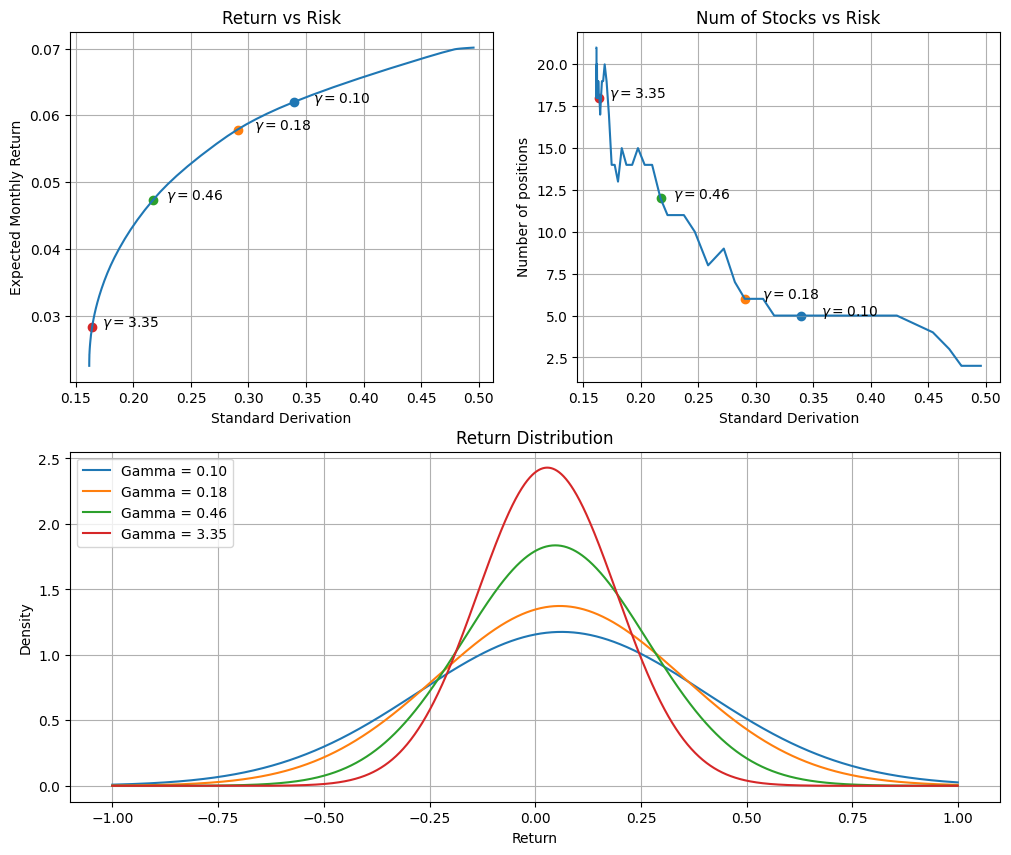

In [6]:
num_pos = [len(w[abs(w) > 0.01]) for w in ws]
gamma_markers_on = [len(gamma_vals)//5, len(gamma_vals)//4, len(gamma_vals)//3, len(gamma_vals)//2]

fig = plt.figure(figsize=(12,10))
gs = GridSpec(2,2)

ax = fig.add_subplot(gs[0,0])
ax.plot(risk_data, ret_data)
for i in gamma_markers_on:
    xx, yy = float(risk_data[i]), float(ret_data[i])
    ax.scatter(xx, yy)
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[i], xy=(xx + xx/20, yy))

ax.set_ylabel("Expected Monthly Return")
ax.set_xlabel("Standard Derivation")
ax.set_title("Return vs Risk")
ax.grid()

ax = fig.add_subplot(gs[0,1])
ax.plot(risk_data, num_pos)
for i in gamma_markers_on:
    xx, yy = float(risk_data[i]), float(num_pos[i])
    ax.scatter(xx, yy)
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[i], xy=(xx + xx/20, yy))
ax.set_ylabel("Number of positions")
ax.set_xlabel("Standard Derivation")
ax.set_title("Num of Stocks vs Risk")
ax.grid()

ax = fig.add_subplot(gs[1,:])
for i in gamma_markers_on:    
    x = np.arange(-1,1,0.001)
    ret = ret_data[i]
    risk = risk_data[i]
    ax.plot(x, stats.norm.pdf(x, ret, risk), label='Gamma = {:.2f}'.format(gamma_vals[i]))

ax.set_title("Return Distribution")
ax.set_ylabel("Density")
ax.set_xlabel("Return")
ax.legend(loc = 'upper left')
ax.grid()

for g in gamma_markers_on:
    weights = pd.DataFrame({"ticker": tickers, 'weight': ws[g]})
    weights['gamma'] = gamma_vals[g]
    weights = weights.set_index(['gamma'])
    weights = weights.sort_values('weight', ascending=False)    
    weights = weights[weights['weight'] > 0.01]    
    display(weights)

## Optimize the portfolios based on given constraints (using factor returns for covariance)

We should compute the factor covariance matrix which better represents the portfolio risk explained by the factor models

Given a factor model

$$r_i = b_1f_1 + b_2f_2 + ...... + b_if_i + e_i$$

and covariance rule
$$\text{cov}(r_i, k*r_j) = k*\text{cov}(r_i,r_j)$$
$$\text{cov}(r_i, r_j+r_k) = \text{cov}(r_i, r_j) + \text{cov}(r_i, r_k)$$

Then covariance of return asset i and j are (they share the same factor returns $f$ )

$$\text{cov}(r_i, r_j) = \text{cov}(b_{i1}f_{1}+b_{i2}f_{2}+......e_i, b_{j1}f_{1}+b_{ij}f_{2}+......e_j )$$
$$\text{cov}(r_i, r_j) = b_{i1}b_{j1} * cov(f_1, f_1) + b_{i1}b_{j2} * cov(f_1, f_2) + b_{i1}b_{j3} * cov(f_1, f_3) + ...... + cov(e_i, e_j)$$

Therefore
 
$$C_{ij} = \vec{b_i} * CF * \vec{b_j^T} + rv_{ij} $$

where
- $b$ is the vector of asset factor exposure
- $CF$ is the factor covariance
- $rv_{ij}$ is the covariance between residual on assets i and j, this will be zero if $i \ne j$

The formula can be generalized to compute the entire covariance matrix for asset returns

$$C = B * CF * B^T + \text{diag}(rv)$$

where
- $B$ is the matrix of factor exposures for all assets in portfolios
- $CF$ is the factor covariance
- $\text{diag}(rv)$ is a matrix with the elements of rv on the main diagonal and zeros elsewhere (given that rv = 0 when $i \ne j$)


Finally, portfolio variance is
$$Var(w) = w * C * w^T$$

If the results looks similar to previous portfolio which we use historical return as covariance, this implies your calculation is correct

In [8]:
ff3 = get_daily_ff3_returns()
ff3 = ff3[ff3['Date'] >= datetime.today() - BDay(120)]
ff3 = ff3[['Mkt-RF', 'SMB', 'HML']].values
ff3_cov = np.cov(ff3.T)
ff3_exposure = df_p[['f_mkt', 'f_smb', 'f_hml']].values

resid_cov = np.cov(res_matrix_p)

cov_m = ff3_exposure @ ff3_cov @ ff3_exposure.T
cov_m = cov_m + np.diag(np.diag(resid_cov))

In [9]:
w = cp.Variable(len(tickers))
gamma = cp.Parameter(nonneg=True)
ret = 21 * expected_returns.T @ w
risk = 21 ** 2 * cp.quad_form(w, cov_m)
constraints = [
    cp.sum(w) == 1,     # uses all cash
    w >= 0,             # long only
    #cp.norm(w,1) <= 2   # max leverage limit
]
prob = cp.Problem(cp.Maximize(ret - gamma * risk), constraints)
gamma_vals = np.logspace(-2, 3, num=100)
risk_data = []
ret_data = []
ws = []

for g in gamma_vals:
    gamma.value = g
    prob.solve()
    risk_data.append(cp.sqrt(risk).value)
    ret_data.append(ret.value)
    ws.append(w.value)

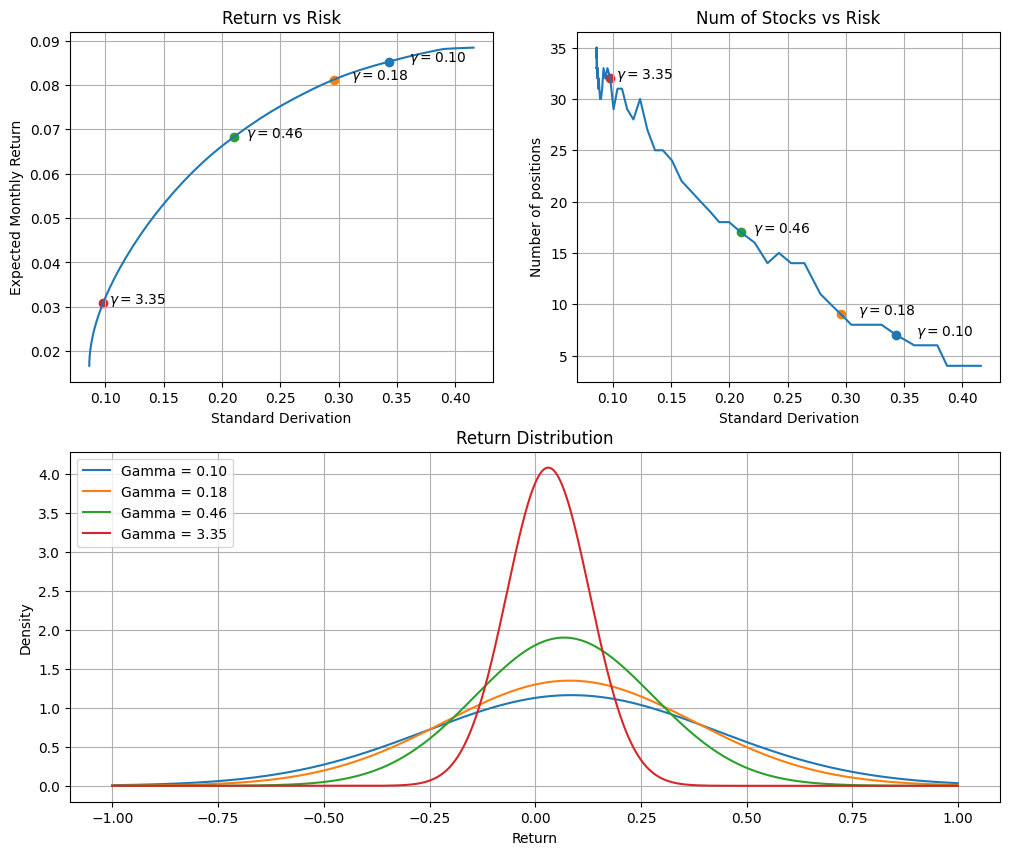

,ticker,weight
gamma,,
0.1024,MPWR,0.2898
0.1024,FSLR,0.2273
0.1024,TSLA,0.1530
0.1024,ENPH,0.1349
0.1024,FTNT,0.0897
0.1024,CDNS,0.0520
0.1024,RCL,0.0466


,ticker,weight
gamma,,
0.1831,CDNS,0.2032
0.1831,MPWR,0.1920
0.1831,FSLR,0.1771
0.1831,FTNT,0.1198
0.1831,TSLA,0.1057
0.1831,ENPH,0.0942
0.1831,RCL,0.0538
0.1831,SEDG,0.0275
0.1831,PWR,0.0128


,ticker,weight
gamma,,
0.4642,CDNS,0.1671
0.4642,LLY,0.1271
0.4642,FSLR,0.1001
0.4642,PWR,0.0853
0.4642,MPWR,0.0759
0.4642,FTNT,0.0754
0.4642,AAPL,0.0663
0.4642,ENPH,0.0454
0.4642,TSLA,0.0452


,ticker,weight
gamma,,
3.3516,LLY,0.0576
3.3516,HSY,0.0554
3.3516,MCK,0.0517
3.3516,MRK,0.0481
3.3516,ABBV,0.0476
3.3516,GIS,0.0446
3.3516,BMY,0.0413
3.3516,ED,0.0375
3.3516,MCD,0.0368


In [10]:
num_pos = [len(w[abs(w) > 0.01]) for w in ws]
gamma_markers_on = [len(gamma_vals)//5, len(gamma_vals)//4, len(gamma_vals)//3, len(gamma_vals)//2]

fig = plt.figure(figsize=(12,10))
gs = GridSpec(2,2)

ax = fig.add_subplot(gs[0,0])
ax.plot(risk_data, ret_data)
for i in gamma_markers_on:
    xx, yy = float(risk_data[i]), float(ret_data[i])
    ax.scatter(xx, yy)
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[i], xy=(xx + xx/20, yy))

ax.set_ylabel("Expected Monthly Return")
ax.set_xlabel("Standard Derivation")
ax.set_title("Return vs Risk")
ax.grid()

ax = fig.add_subplot(gs[0,1])
ax.plot(risk_data, num_pos)
for i in gamma_markers_on:
    xx, yy = float(risk_data[i]), float(num_pos[i])
    ax.scatter(xx, yy)
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[i], xy=(xx + xx/20, yy))
ax.set_ylabel("Number of positions")
ax.set_xlabel("Standard Derivation")
ax.set_title("Num of Stocks vs Risk")
ax.grid()

ax = fig.add_subplot(gs[1,:])
for i in gamma_markers_on:    
    x = np.arange(-1,1,0.001)
    ret = ret_data[i]
    risk = risk_data[i]
    ax.plot(x, stats.norm.pdf(x, ret, risk), label='Gamma = {:.2f}'.format(gamma_vals[i]))

ax.set_title("Return Distribution")
ax.set_ylabel("Density")
ax.set_xlabel("Return")
ax.legend(loc = 'upper left')
ax.grid()
plt.show()

for g in gamma_markers_on:
    weights = pd.DataFrame({"ticker": tickers, 'weight': ws[g]})
    weights['gamma'] = gamma_vals[g]
    weights = weights.set_index(['gamma'])
    weights = weights.sort_values('weight', ascending=False)    
    weights = weights[weights['weight'] > 0.01]    
    display(weights)


# Backtest the portfolio, assume portfolios is rebalanced monthly
1. Strategy to generate portfolios weights $w_t$
2. Function to pickup the portfolios and calculate returns for next 1 months

For each monthly rebalance, it tries to lookback for 180 business days and re-calculate all factor exposures, then conduct a portfolio optimization. This avoid look-ahead bias.

<b>However, the back-testing results would have survivorship bias, becuase the assets universe are based on SP500 as of todays, only good stocks upto today are survived and in SP500</b>

<i>in order to reproduce above notebooks results, use set d = today()</i>

In [11]:
def ffm_portfolio(raw, date, fit_lookback, ev_lookback, gamma_val, plot=False):

    df = raw[(raw['Date'] <= date)&(raw['Date'] > date - BDay(fit_lookback))]    
    tickers = list(df['Close'].columns)

    ff3 = get_daily_ff3_returns()    
    ff3 = ff3.rename(columns={'RF':'RFree'})    
    df = df[['Date','Close']]
    df['Close'] = df['Close'].pct_change().fillna(0)
    df = df.droplevel(0, axis=1)
    df = df.rename(columns={'': 'Date'})
    df = pd.merge(df, ff3, how='inner', on='Date', validate='1:1')

    # residual matrix, we will need this to compute the factor portfolio covariance
    res_matrix = []

    # fit linear regression to find factor exposure
    ff3_factors_arr = []     

    for ticker in tickers:    
        X = df[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)
        y = df[ticker] - df['RFree']
        
        ff_model = sm.OLS(y, X).fit()
        intercept, b1, b2, b3 = ff_model.params
        intercept_p, b1_p, b2_p, b3_p = ff_model.pvalues
        row = {
            'ticker': ticker,
            'f_mkt': b1,
            'f_smb': b2,
            'f_hml': b3,
            'f_const': intercept,            
            'p_mkt': b1_p,
            'p_smb': b2_p,
            'p_hml': b3_p,
            'p_const': intercept_p,
            'is_mkt_f_true': b1_p < 0.05,
            'is_smb_f_true': b2_p < 0.05,
            'is_hml_f_true': b3_p < 0.05,
            'is_const_f_true': intercept_p < 0.05,
        }
        ff3_factors_arr.append(row)
        res_matrix.append(ff_model.resid)

    ff3_factors = pd.DataFrame(ff3_factors_arr)
    res_matrix = np.array(res_matrix)    

    # restrict universe    
    filters = (ff3_factors['is_mkt_f_true'] == True) & (ff3_factors['is_smb_f_true'] == True) & (ff3_factors['is_hml_f_true'] == True)
    df_p = ff3_factors[filters]
    res_matrix_p = res_matrix[filters]
    tickers = list(df_p['ticker'].values)

    # derive expected returns
    ff3 = get_daily_ff3_returns()
    ff3 = ff3[ff3['Date'] >= date - BDay(ev_lookback)]
    mkt_rf = ((1 + ff3['Mkt-RF']).prod() - 1) / len(ff3)
    smb = ((1 + ff3['SMB']).prod() - 1) / len(ff3) 
    hml = ((1 + ff3['HML']).prod() - 1) / len(ff3) 
    rf = ((1 + ff3['RF']).prod() - 1) / len(ff3)

    df_p['mkt_rf'] = mkt_rf
    df_p['smb'] = smb
    df_p['hml'] = hml
    df_p['rf'] = rf
    df_p['expected_return'] = \
        df_p['rf'] + \
        df_p['f_mkt'] * df_p['mkt_rf'] + \
        df_p['f_smb'] * df_p['smb'] + \
        df_p['f_hml'] * df_p['hml'] + \
        df_p['f_const']
        
    expected_returns = df_p['expected_return'].values
    
    # derive portfolio variance
    ff3 = get_daily_ff3_returns()
    ff3 = ff3[ff3['Date'] >= date - BDay(ev_lookback)]
    ff3_cov = np.cov(ff3[['Mkt-RF', 'SMB', 'HML']].values.T)    
    ff3_exposure = df_p[['f_mkt', 'f_smb', 'f_hml']].values
    resid_cov = np.cov(res_matrix_p)

    cov_m = ff3_exposure @ ff3_cov @ ff3_exposure.T
    cov_m = cov_m + np.diag(np.diag(resid_cov))

    # optimize portfolios
    w = cp.Variable(len(tickers))
    gamma = cp.Parameter(nonneg=True)
    ret = 21 * expected_returns.T @ w
    risk = 21 ** 2 * cp.quad_form(w, cov_m)
    constraints = [
        cp.sum(w) == 1,     # uses all cash
        w >= 0,             # long only        
    ]
    gamma.value = gamma_val
    prob = cp.Problem(cp.Maximize(ret - gamma * risk), constraints)
    prob.solve()

    # get the output weights
    weights = w.value
    weights = pd.DataFrame({"ticker": tickers, 'weight': weights})
    weights = weights[weights['weight'] > 0.01]
    weights['weight'] = weights['weight'] / sum(weights['weight'])
    weights['Date'] = date
    weights = pd.pivot_table(weights, columns='ticker', index='Date', values=['weight'], aggfunc=np.sum, fill_value=0)

    # plot the portfolios analysis
    if plot:
        gamma_vals = np.logspace(-2, 3, num=100)
        risk_data = []
        ret_data = []
        ws = []

        for g in gamma_vals:
            gamma.value = g
            prob.solve()
            risk_data.append(cp.sqrt(risk).value)
            ret_data.append(ret.value)
            ws.append(w.value)

        num_pos = [len(w[abs(w) > 0.01]) for w in ws]
        gamma_markers_on = [len(gamma_vals)//5, len(gamma_vals)//4, len(gamma_vals)//3, len(gamma_vals)//2]

        fig = plt.figure(figsize=(12,10))
        gs = GridSpec(2,2)

        ax = fig.add_subplot(gs[0,0])
        ax.plot(risk_data, ret_data)
        for i in gamma_markers_on:
            xx, yy = float(risk_data[i]), float(ret_data[i])
            ax.scatter(xx, yy)
            ax.annotate(r"$\gamma = %.2f$" % gamma_vals[i], xy=(xx + xx/20, yy))

        ax.set_ylabel("Expected Monthly Return")
        ax.set_xlabel("Standard Derivation")
        ax.set_title("Return vs Risk")
        ax.grid()

        ax = fig.add_subplot(gs[0,1])
        ax.plot(risk_data, num_pos)
        for i in gamma_markers_on:
            xx, yy = float(risk_data[i]), float(num_pos[i])
            ax.scatter(xx, yy)
            ax.annotate(r"$\gamma = %.2f$" % gamma_vals[i], xy=(xx + xx/20, yy))
        ax.set_ylabel("Number of positions")
        ax.set_xlabel("Standard Derivation")
        ax.set_title("Num of Stocks vs Risk")
        ax.grid()

        ax = fig.add_subplot(gs[1,:])
        for i in gamma_markers_on:    
            x = np.arange(-1,1,0.001)
            ret = ret_data[i]
            risk = risk_data[i]
            ax.plot(x, stats.norm.pdf(x, ret, risk), label='Gamma = {:.2f}'.format(gamma_vals[i]))

        ax.set_title("Return Distribution")
        ax.set_ylabel("Density")
        ax.set_xlabel("Return")
        ax.legend(loc = 'upper left')
        ax.grid()
        plt.show()        

    return weights

In [12]:
tickers = get_sp500_tickers()
raw = yf.download(tickers=tickers,period="7y",interval="1d",auto_adjust=True).reset_index()

[*********************100%***********************]  503 of 503 completed


In [13]:
fit_lookback = 500
ev_lookback = 120
gamma_val = 0.5

start_date, end_date = raw['Date'].min() + BDay(fit_lookback), raw['Date'].max()

dates = pd.date_range(start_date, end_date, freq='M')
ports = []

with tqdm(total=len(dates)) as pbar:
    for d in dates:        
        port = ffm_portfolio(raw, d, fit_lookback, ev_lookback, gamma_val)
        ports.append(port)
        pbar.update(1)

100%|██████████| 61/61 [00:58<00:00,  1.04it/s]


In [14]:
def calc_port_return(x, ports_assets):
    rets = 0
    for a in ports_assets:
        rets += x[('Close', a)] * x[('weight', a)]
    return rets

df_ports = pd.concat(ports).fillna(0)
df_ports = df_ports.resample('D').ffill()
ports_assets = list(map(lambda x: x[1], df_ports.columns))

df_returns = raw.copy()
df_returns = df_returns.set_index('Date')
df_returns = ((df_returns.shift(-1) - df_returns) / df_returns).fillna(0)
df_returns = pd.merge(df_ports, df_returns, on='Date', how='inner', validate='1:1')
df_returns['port_return'] = df_returns.apply(lambda x: calc_port_return(x, ports_assets), axis=1)
df_returns['cum_return'] = (df_returns['port_return'] + 1).cumprod()
df_returns = df_returns.reset_index()

[*********************100%***********************]  1 of 1 completed


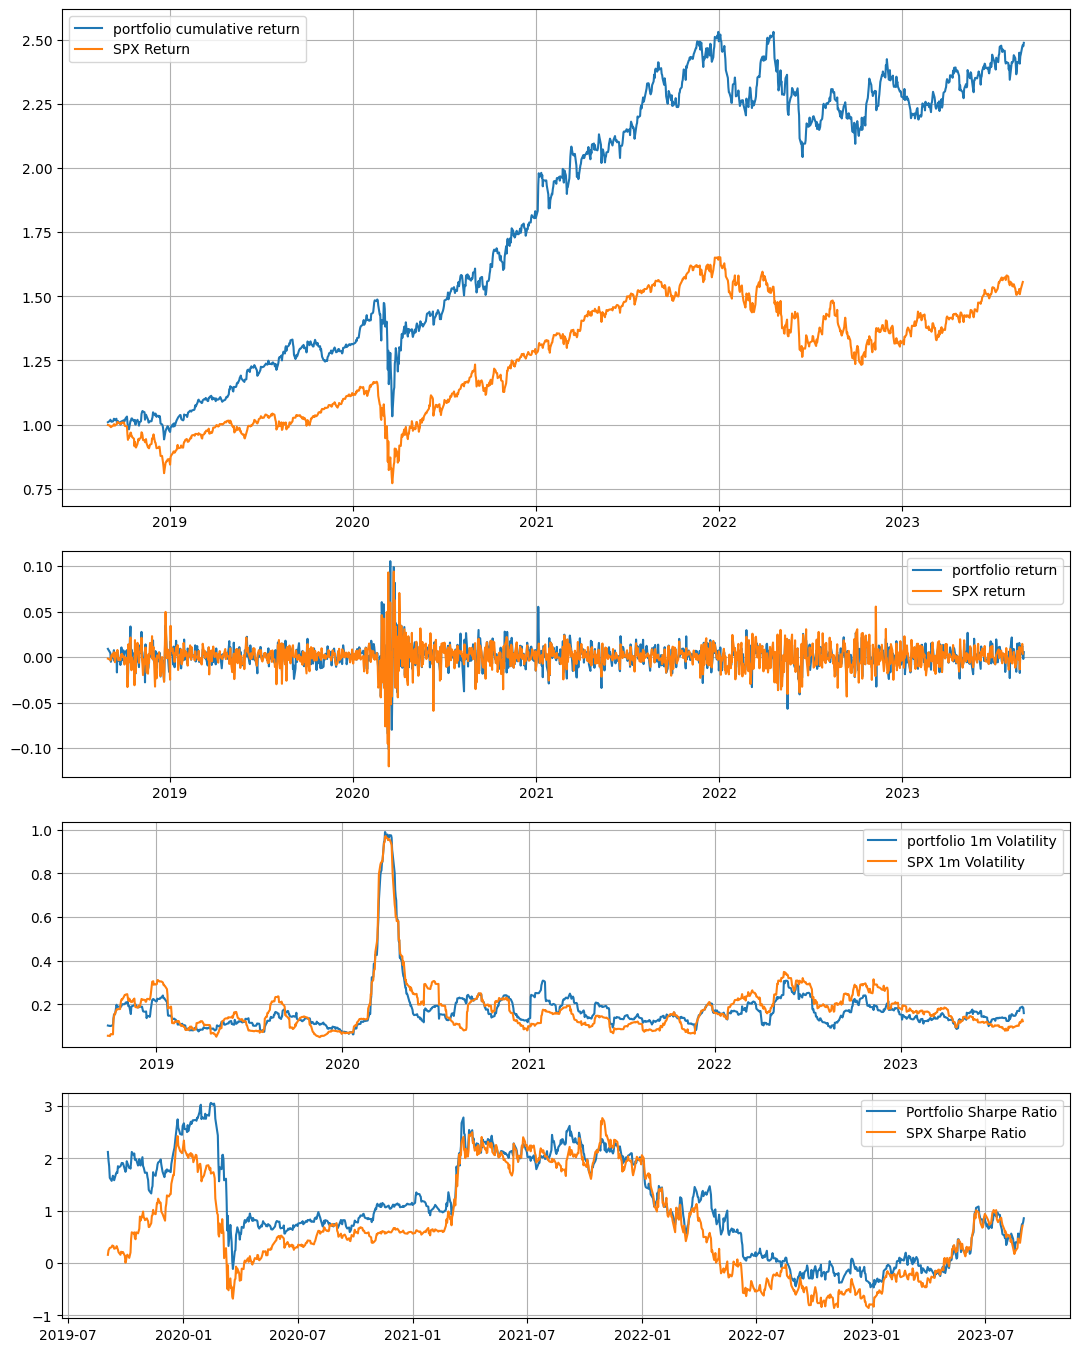

In [15]:
spx = yf.download(
    tickers='^SPX', 
    start=min(df_returns['Date']), 
    end=max(df_returns['Date']), 
    interval="1d",auto_adjust=True).reset_index()
spx = spx.set_index('Date')
spx = (spx.shift(-1) - spx)/spx
spx['cum_return'] = (spx['Close'] + 1).cumprod()
spx = spx.reset_index()

fig = plt.figure(figsize=(13,17))
gs = GridSpec(5,1)

ax = fig.add_subplot(gs[0:2])
ax.plot(df_returns['Date'], df_returns['cum_return'], label='portfolio cumulative return')
ax.plot(spx['Date'], spx['cum_return'], label='SPX Return')
ax.grid()
ax.legend()

ax = fig.add_subplot(gs[2])
ax.plot(df_returns['Date'], df_returns['port_return'], label='portfolio return')
ax.plot(spx['Date'], spx['Close'], label='SPX return')
ax.grid()
ax.legend()

ax = fig.add_subplot(gs[3])
ax.plot(df_returns['Date'], np.sqrt(252) * df_returns['port_return'].rolling(20).std(), label='portfolio 1m Volatility')
ax.plot(spx['Date'], np.sqrt(252) * spx['Close'].rolling(20).std(), label='SPX 1m Volatility')
ax.grid()
ax.legend()

ax = fig.add_subplot(gs[4])
ax.plot(df_returns['Date'], np.sqrt(252) * df_returns['port_return'].rolling(252).mean() / df_returns['port_return'].rolling(252).std(), label='Portfolio Sharpe Ratio')
ax.plot(spx['Date'], np.sqrt(252) * spx['Close'].rolling(252).mean() / spx['Close'].rolling(252).std(), label='SPX Sharpe Ratio')
ax.grid()
ax.legend()